# Distributed Compute Protocol with Python and Node

The idea behind this application is to demonstrate the unreasonable effectiveness of distributing tensorflow model inferencing and training jobs using a jupyter notebook with shared parameters with the python runtime. Allowing for data loading to be done in whatever language you're most familiar with and allowing you to parallelize whatever you may need to parallelize.

![pixiedust_node](images/pixiedust_node_schematic.png)


In the following cell, we initialize tensorflow, numpy and pixiedust_node. Pixiedust_node connects the ipython kernel to a node repl running in the background. 

We then initialize a few parameters for our identity keystore, our account keystore and the scheduler we'd like to target our jobs to go to. Addition, we clear the node instance `node.clear()`, we use `job-utility` to cancel all jobs running with our specific ID, Account and scheduler. `job-utility` must be installed globally using npm. Note that the exclamation marks are bash commands.

Finally we install dcp-client in the specific npm location for the repl by using `npm.install`. 



### Note

This is still an experimental tool and so sometimes pipes will die and consoles will go to the wrong place, please keep that in mind and just restart and clear all outputs if anything goes wrong.

In [1]:
import tensorflow as tf
import numpy as np
try:
    import pixiedust_node
except:
    !pip install pixiedust pixiedust_node
    import pixiedust_node

ID_KEY_LOC  = '/home/mgasmallah/DCP/keys/id.keystore'
ACC_KEY_LOC = '/home/mgasmallah/DCP/keys/AISTEST.keystore'
SCHEDULER    = 'https://demo-scheduler.distributed.computer'

node.clear();
!job-utility cancelAllJobs -I $ID_KEY_LOC --default-bank-account-file $ACC_KEY_LOC --scheduler $SCHEDULER
npm.install( 'dcp-client')

Pixiedust database opened successfully


pixiedust_node 0.2.5 started. Cells starting '%%node' may contain Node.js code.
Clearing context...
Sending request cancelAllJobs...
{
  "description": "Cancelled 0 jobs.",
  "stats": []
}
/home/mgasmallah/.nvm/versions/node/v10.20.1/bin/npm install -s dcp-client
+ dcp-client@3.1.13
added 7 packages from 4 contributors, updated 1 package and audited 921 packages in 10.535s
10 packages are looking for funding
run `npm fund` for details
found 0 vulnerabilities


Note that any cell with the magic `%%node` is now run on the node backend and any cell without this magic is in python. Note that any python variable of type `str`, `int`, `float`, `bool`, `dict`, or `list` will be moved to node when that cell is executed. Additionally, the node and python variables are synced every second. Additionally, any variable declared with `var` in a `%%node` cell is automatically copied to the equivalent variable in python.

Now that we have installed everything we need, we can initialize all the variables and values required for DCP to be used. In this case we add our ID key, account key and scheduler to the proccess argv in order to tell dcp where to find everything. Since there is no top level await, we simply use `initSync(process.argv)`. This allows us to now require `dcp/compute`, `dcp/wallet`, and `dcp/dcp-cli`. 

We also need an accountKeystore and an identityKeystore, however those are got asynchronously, so we'll initialize the variables here and fill them in later.

In [2]:
%%node

process.argv.push('-I', ID_KEY_LOC, '--default-bank-account-file',ACC_KEY_LOC, '--scheduler', SCHEDULER);
require('dcp-client').initSync(process.argv)
const compute = require('dcp/compute');
const wallet = require('dcp/wallet');
const dcpCli = require('dcp/dcp-cli');
var accountKeystore;
var identityKeystore;


This is the first concrete simple example of distributing a job using DCP in a node cell. Since this process is asynchronous and doesn't quite sync up with ipython kernel, when this is run, you should wait until you have fully completed execution of the function. 

We begin by geting our identity keystore and our account keystore. Once these are loaded in we initialize our job using `compute.for`. `compute.for` takes an array of which each slice will be sent to a worker as an argument to the worker function. The worker function is the second argument and is what will be executed on each worker.

We throw in some `job.on` overrides so we can log our progress through distribution.

In [3]:
%%node

async function main(){
    identityKeystore = await dcpCli.getIdentityKeystore();
    wallet.addId(identityKeystore);
    accountKeystore = await dcpCli.getAccountKeystore();
    console.log("Loaded Keystore");
    let job = compute.for([...Array(1).keys()], async function(sim_id){
        progress(0.01);
        console.log("Beginning require with index: ", sim_id);
        const tf = require('aistensorflow/tfjs');
        console.log(tf.version);
        progress(1.0);
        return "done";
    });

    job.on('accepted', ()=>{
        console.log('Job accepted...');
    });
    job.on('status', (status)=>{
        console.log('Got a status update: ', status);
    });
    job.on('console', (output)=>{
        console.log(output.message);
    });
    job.on('error', (err)=>{
        console.log(err);
    });
    job.requires('aistensorflow/tfjs');
    job.public.name = 'dcp-testing';
    console.log("Launching job");
    await job.exec(compute.marketValue, accountKeystore);
    
    console.log("Done executing job");
};

main();

... ... ... ... ... ..... ..... ..... ..... ..... ..... ..... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ...
Loaded Keystore
Launching job
Job accepted...
Got a status update:  { runStatus: 'SLOWWORK', total: 1, distributed: 0, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 1, distributed: 1, computed: 0 }
Beginning require with index:  0
{"tfjs-core":"2.3.0","tfjs-backend-cpu":"2.3.0","tfjs-backend-webgl":"2.3.0","tfjs-data":"2.3.0","tfjs-layers":"2.3.0","tfjs-converter":"2.3.0","tfjs":"2.3.0"}
Got a status update:  { runStatus: 'WAITING', total: 1, distributed: 1, computed: 1 }
Done executing job


Now let's demonstrate the neat things we can do with python-js bridging. Here we take advantage of the python tensorflow implementation which comes with mnist. We load this data in and do our data preprocessing in python.

Once we have finished our data preprocessing, we convert the data to a list and initialize our results array in python as well. This allows us to sync to the js instance in the back.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Change datatype
x_train = x_train.astype(np.uint8)
x_test  = x_test.astype(np.uint8)

#change [60000] to [60000,10] (one_hot)
y_train = tf.one_hot(y_train, 10).numpy()
y_test  = tf.one_hot(y_test, 10).numpy()

#reshape from a [-1,28,28] to a [-1,783] 
x_train = x_train.reshape(-1,784)
x_test  = x_test.reshape(-1, 784)

#We choose the first 1000 samples for training and reshape to [-1] and convert to a list
x_train = x_train[:1000].reshape(-1).tolist()
y_train = y_train[:1000].reshape(-1).tolist()
#initialize a list to use in js and python
mnistResults = []

Here we confirm that the arrays have been send to the js instance by logging their type and their length.

In [5]:
%%node
console.log(x_train.length, typeof x_train);
console.log(mnistResults);

784000 'object'
[]



Here we split up our data into batches to send off to the protocol for training. This is (for the majority) the same as previous main function, but does a few things more in splitting up the data and in adding to the work function. Additionally, this is the first time we use the `job.requires` syntax. Although you could `npm.install( '@tensorflow/tfjs')` and `job.requires('@tensorflow/tfjs')`, we provide a module on DCP called `aistensorflow/tfjs` which has all of tfjs and is confirmed working for DCP.

Finally, note that we have added on the `job.on(results,()....` a push to the `mnistResults` variable declared in python above. 

In [6]:
%%node
async function main(){
    let xtrain = Uint8Array.from(x_train);
    let ytrain = Uint8Array.from(y_train);
    let batch = 32;
    
    
    let trainingArray = [];
    
    for (let i=0;i< Math.floor(xtrain.length/784);i+=batch){
        let xs = Array.from(xtrain.slice(i*784, Math.min(xtrain.length, (i+batch)*784)));
        let ys = Array.from(ytrain.slice(i*10, Math.min(ytrain.length, (i+batch)*10)));
        trainingArray.push({xs, ys, batch});
    }
    
    let job = compute.for(trainingArray, async function(data){
        progress();
        const tf = require('aistensorflow/tfjs');
        tf.setBackend('cpu');
        await tf.ready();
        
        const model = tf.sequential({
            layers: [
                tf.layers.dense({inputShape: [784], units:32, activation: 'relu'}),
                tf.layers.dense({units: 64, activation: 'relu'}),
                tf.layers.dense({units: 128, activation: 'relu'}),
                tf.layers.dense({units: 10, activation: 'softmax'})
            ]
        });
        progress();
        model.compile({
            optimizer: 'sgd',
            loss: 'categoricalCrossentropy',
            metrics: ['accuracy']
        })
        console.log("Model has been built.");
        model.summary();
        
        console.log("Data length: ", data.xs.length, data.ys.length);
    
        let xTrain = tf.tensor(data.xs, [data.xs.length/784, 784], dtype='float32');
        let yTrain = tf.tensor(data.ys, [data.ys.length/10, 10], dtype='int32');
        
        console.log(xTrain.shape, yTrain.shape);
        
        const history = await model.fit(xTrain, yTrain, {
            epochs: 5,
            callbacks: {
                onEpochEnd: async (epochs, logs)=>{
                    progress();
                }
            }
        });
        progress(1.0);
        return history.history.acc;
    });

    job.on('accepted', ()=>{
        console.log('Job accepted...');
    });
    job.on('status', (status)=>{
        console.log('Got a status update: ', status);
    });
    job.on('result', (value)=>{
        let result = value.result;
        mnistResults.push(result[result.length-1]);
        
    });
    job.on('console', (output)=>{
        console.log(output.message);
    });
    job.on('error', (err)=>{
        console.log(err);
    });
    job.requires('aistensorflow/tfjs');
    job.public.name = 'dcp-vae-testing';
    console.log("Launching job");
    await job.exec(compute.marketValue, accountKeystore);
    console.log("Done executing job");
};

main();

... ... ... ... ... ... ... ... ..... ..... ..... ..... ... ... ..... ..... ..... ..... ..... ..... ....... ....... ....... ....... ....... ....... ....... ..... ..... ....... ....... ....... ....... ..... ..... ..... ..... ..... ..... ..... ..... ..... ..... ..... ....... ....... ......... ........... ........... ......... ....... ..... ..... ..... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ...
Launching job
Job accepted...
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 0, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 1, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 2, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 3, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 4, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 5, computed

Total params: 36842
Trainable params: 36842
Non-trainable params: 0
_________________________________________________________________
Data length:  25088 320
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 17, computed: 6 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 18, computed: 6 }
[32,784] [32,10]
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 19, computed: 6 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 20, computed: 6 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 21, computed: 6 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 22, computed: 6 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 23, computed: 6 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 24, computed: 6 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 25, computed: 6 }
Got a status update:  { 

Got a status update:  { runStatus: 'WAITING', total: 32, distributed: 32, computed: 11 }
Got a status update:  { runStatus: 'WAITING', total: 32, distributed: 32, computed: 11 }
Model has been built.
Total params: 36842
Trainable params: 36842
Non-trainable params: 0
_________________________________________________________________
Data length:  25088 320
[32,784] [32,10]
_________________________________________________________________
Total params: 36842
Trainable params: 36842
Non-trainable params: 0
_________________________________________________________________
Data length:  25088 320
Model has been built.
Model has been built.
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output shape              Param #
Layer (type)                 Output shape              Param #
[32,784] [32,10]
dense_Dense5 (Dense)         [null,32]                 25120
_____________________

dense_Dense4 (Dense)         [null,10]                 1290
Total params: 36842
Trainable params: 36842
Non-trainable params: 0
_________________________________________________________________
Data length:  25088 320
[32,784] [32,10]
Model has been built.
_________________________________________________________________
Layer (type)                 Output shape              Param #
dense_Dense9 (Dense)         [null,32]                 25120
_________________________________________________________________
_________________________________________________________________
dense_Dense10 (Dense)        [null,64]                 2112
Got a status update:  { runStatus: 'WAITING', total: 32, distributed: 32, computed: 20 }
dense_Dense11 (Dense)        [null,128]                8320
_________________________________________________________________
dense_Dense12 (Dense)        [null,10]                 1290
Total params: 36842
Trainable params: 36842
Non-trainable params: 0
__________________

[32,784] [32,10]
[32,784] [32,10]
Model has been built.
_________________________________________________________________
Layer (type)                 Output shape              Param #
dense_Dense1 (Dense)         [null,32]                 25120
_________________________________________________________________
dense_Dense2 (Dense)         [null,64]                 2112
_________________________________________________________________
dense_Dense3 (Dense)         [null,128]                8320
_________________________________________________________________
dense_Dense4 (Dense)         [null,10]                 1290
Total params: 36842
Trainable params: 36842
Non-trainable params: 0
_________________________________________________________________
Data length:  25088 320
Got a status update:  { runStatus: 'WAITING', total: 32, distributed: 32, computed: 31 }
Got a status update:  { runStatus: 'WAITING', total: 32, distributed: 32, computed: 31 }
[32,784] [32,10]
Got a status update:  {

Now that we have all these results and they are available in python, we can do some very quick data visualization in python! Here we use matplotlibs pyplot to plot the accuracies of each worker. 

Text(0, 0.5, 'Accuracy')

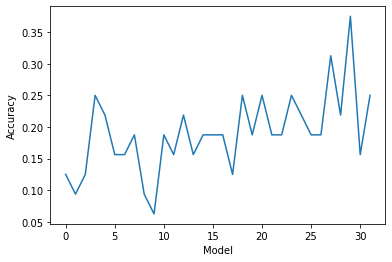

In [7]:
import matplotlib.pyplot as plt
plt.plot(mnistResults)
plt.xlabel("Model")
plt.ylabel("Accuracy")

# Tensorflow to DCP

In this section we will train a model in python, convert it to js and ship it off to DCP as a module that we can require. First we begin by requiring the python tensorflowjs package which allows for python to js conversion of models.

In [8]:
try:
    import tensorflowjs as tfjs
except:
    !pip install tensorflowjs tf-estimator-nightly
    import tensorflowjs as tfjs

Now we simply use the mnist dataset to train a simple network on mnist in python and evaluate it's performance.

In [9]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 1s 552us/step - loss: 0.2955 - accuracy: 0.9148
Epoch 2/5
1875/1875 [==============================] - 1s 573us/step - loss: 0.1423 - accuracy: 0.9580
Epoch 3/5
1875/1875 [==============================] - 1s 553us/step - loss: 0.1067 - accuracy: 0.9679
Epoch 4/5
1875/1875 [==============================] - 1s 548us/step - loss: 0.0876 - accuracy: 0.9731
Epoch 5/5
313/313 [==============================] - 0s 454us/step - loss: 0.0761 - accuracy: 0.9755


[0.07607768476009369, 0.9754999876022339]

Now using tensorflowjs in python and a tensorflowjs utility we have built, we can save the model to a directory and publish this model to DCP. Note that the `-p` package version number must be incremented everytime if the package name `dcp_mnist_ex/mnist.js` is not changed. 

In [10]:
!mkdir './tfjs_model'
tfjs.converters.save_keras_model(model, './tfjs_model')
!ls './tfjs_model'
!node ~/DCP/dcp-utils/tfjs_utils/bin/serializeModel.js -m ./tfjs_model/model.json -o dcp_mnist_ex/mnist.js -p 1.0.6 -d

mkdir: cannot create directory ‘./tfjs_model’: File exists
group1-shard1of1.bin  model.json


/home/mgasmallah/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


2020-08-26 10:18:01.384864: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-08-26 10:18:01.413744: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2020-08-26 10:18:01.414261: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4d803e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-08-26 10:18:01.414279: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
Module published at :  dcp_mnist_ex/mnist.js
Done


Now to use this model is pretty trivial. We use the same `x_train`and `y_train` variables in node that we had from before and batch them for inference using our model. We require `aistensorflow/tfjs` and `dcp_mnist_ex/mnist.js` as well as `dcp-polyfills/polyfills.js`. This allows us to `await require('mnist').getModel()` to get the mnist model we built. In order to evaluate we have to compile the model with a loss and an accuracy. Finally we evaluate the model and return our accuracy. We have reset mnistResults and so we can use it to fill it in with our accuracy.

In [11]:
%%node
mnistResults = [];
async function main(){
    let xtrain = Uint8Array.from(x_train);
    let ytrain = Uint8Array.from(y_train);
    let batch = 32;
    
    
    let trainingArray = [];
    
    for (let i=0;i< Math.floor(xtrain.length/784);i+=batch){
        let xs = Array.from(xtrain.slice(i*784, Math.min(xtrain.length, (i+batch)*784)));
        let ys = Array.from(ytrain.slice(i*10, Math.min(ytrain.length, (i+batch)*10)));
        trainingArray.push({xs, ys, batch});
    }
    
    let job = compute.for(trainingArray, async function(data){
        progress();
        require('polyfills');
        const tf = require('aistensorflow/tfjs');
        tf.setBackend('cpu');
        await tf.ready();
        
        const model = await require('mnist').getModel();
        
        let xTrain = tf.tensor(data.xs, [data.xs.length/784, 28, 28], dtype='float32');
        let yTrain = tf.tensor(data.ys, [data.ys.length/10, 10], dtype='int32');
        
        
        model.compile({
            optimizer: 'sgd',
            loss: 'categoricalCrossentropy',
            metrics: ['accuracy']
        })
        
        const result = model.evaluate(xTrain, yTrain, {
            batchSize: 32,
        })[1];
        
        progress(1.0);
        return result.dataSync()[0];
    });

    job.on('accepted', ()=>{
        console.log('Job accepted...');
    });
    job.on('status', (status)=>{
        console.log('Got a status update: ', status);
    });
    job.on('result', (value)=>{
        mnistResults.push(value.result);
        
    });
    job.on('console', (output)=>{
        console.log(output.message);
    });
    job.on('error', (err)=>{
        console.log(err);
    });
    
    job.requires('dcp-polyfills/polyfills');
    job.requires('aistensorflow/tfjs');
    job.requires('dcp_mnist_ex/mnist');
    
    
    job.public.name = 'dcp-vae-testing';
    console.log("Launching job");
    await job.exec(compute.marketValue, accountKeystore);
};

main();

... ... ... ... ... ... ... ... ..... ..... ..... ..... ... ... ..... ..... ..... ..... ..... ..... ..... ..... ..... ..... ..... ..... ..... ....... ....... ....... ....... ..... ..... ....... ....... ..... ..... ..... ..... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ... ...
Launching job
Job accepted...
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 0, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 1, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 2, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 3, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 4, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 5, computed: 0 }
Got a status update:  { runStatus: 'SLOWWORK', total: 32, distributed: 6, computed: 0 }
Got a status update:

In [12]:
print("Accuracy for entire set: ", sum(mnistResults)/len(mnistResults))

Accuracy for entire set:  0.9833984375
